# 房价预测案例（高阶版）

## 加载数据

In [2]:
# 系统库
import os, sys

# 自带数据
datalib_path = os.path.join(os.path.abspath('.'), '../../')
sys.path.append(datalib_path)
import dataset

import numpy as np
import pandas as pd
train_df = pd.read_csv(
    os.path.join(dataset.house_path, 'lab/train.csv'), index_col=0)
test_df = pd.read_csv(
    os.path.join(dataset.house_path, 'lab/test.csv'), index_col=0)

## 探索数据

In [3]:
print(train_df.head())
print(train_df.info)
print(train_df.shape)

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ... 

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

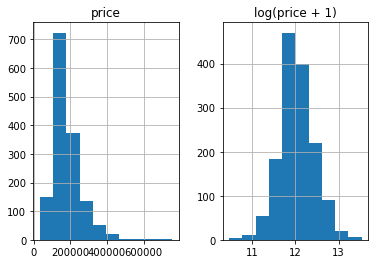

In [4]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

## 预处理

### 用SalePrice作为Label

In [5]:
y_train = np.log1p(train_df.pop('SalePrice'))

### 合并数据

In [6]:
all_df = pd.concat((train_df, test_df), axis=0) # 合并训练、测试集
print(all_df.shape)
print(y_train.head())

(2919, 79)
Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64


### MSSubClass One-hot Encode

In [7]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [8]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)  # from int to str
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

### 把category的特征转变成numerical

In [9]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()  # 将分类数据转换为数值型数据
# 此刻MSSubClass被我们分成了12个column，每一个代表一个category。是就是1，不是就是0。

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [10]:
all_dummy_df = pd.get_dummies(all_df)  # 把所有的category数据都给One-Hot Encode了
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


### 预处理numerical变量

In [11]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10) # 将数据中有缺失项的属性统计出来并从大到小排序

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtUnfSF         1
GarageArea        1
TotalBsmtSF       1
GarageCars        1
BsmtFinSF2        1
dtype: int64

In [12]:
mean_cols = all_dummy_df.mean()  # 得到所有列的平均值
print(mean_cols.head(10))   # 打印出前10列数据的平均值
all_dummy_df = all_dummy_df.fillna(mean_cols) # 用每一列的平均值填充每一列中的NAN项
all_dummy_df.isnull().sum().sum()  # 检查是否还有 NAN 值

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64


0

### 标准化numerical特征

In [13]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']  # 哪些是numerical的
print(numeric_cols)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [14]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()  # 算出每一个数值型的属性下数据的平均值
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()  # 算出每一个数值型的属性下数据的方差
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std  # 计算标准分布

### 把数据集分回训练集和测试集

In [15]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
print(dummy_train_df.shape)
print(dummy_test_df.shape)
X_train = dummy_train_df.values
X_test = dummy_test_df.values

(1460, 303)
(1459, 303)


## 模型训练

### Ridge Regression
以Ridge作为弱分类器

In [16]:
from sklearn.linear_model import Ridge
ridge = Ridge(15)

### Bagging through Cross Validation
Bagging基于多个Ridge弱分类器，每个train随机的一部分数据集，然后把它们的最终结果综合起来（多数投票制）。

Text(0.5, 1.0, 'n_estimator vs CV Error')

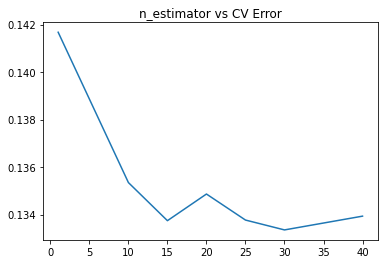

In [17]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

在之前的版本中，Ridge最优结果也就是0.135；而这里使用25个弱Ridge分类器的bagging达到了低于0.132的结果。

如果并没有提前训练Ridge模型，也可以用Bagging自带的DecisionTree模型：代码是一样的，把base_estimator给删去即可。

Text(0.5, 1.0, 'n_estimator vs CV Error')

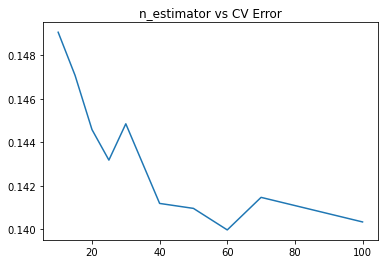

In [18]:
params = [10, 15, 20, 25, 30, 40, 50, 60, 70, 100]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

看来单纯用DT不太有效，最好的结果也就0.140。

### Boosting
Boosting比Bagging理论上更高级点，也是采用一组弱类器。但把他们线性排列，下一个弱分类器把上一个弱分类器分类得到的不好地方加上更高的权重，这样下一个弱分类器就能在这个部分学得更加“深刻”。

Text(0.5, 1.0, 'n_estimator vs CV Error')

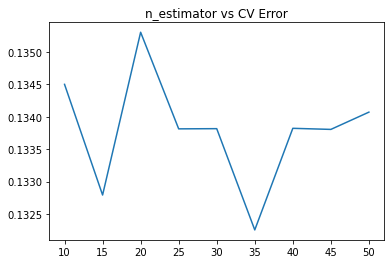

In [19]:
from sklearn.ensemble import AdaBoostRegressor
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

Adaboost+Ridge在这里，25个小分类器的情况下，也是达到了接近0.132的效果。

同理，这里也可以不必输入Base_estimator，使用Adaboost自带的DT。

In [20]:
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

### XGBoost

Text(0.5, 1.0, 'max_depth vs CV Error')

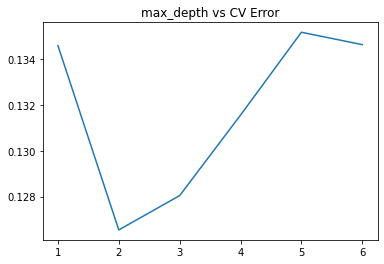

In [ ]:
from xgboost import XGBRegressor
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error")

惊了，深度为2的时候，错误率缩小到0.127。